
# Seis2Rock - Volve Dataset <br> 
## Petrophysical Inversion on the well NO 15 9-19 A



This notebook provides an illustration of the petrophysical inversion carried only on the Well NO 15 9-19 A. In this case, we will try to do a benchmark of our method. Here we construct the AVO syntethic gather and we use the same as data for the inversion. It is a way to veryfy the method gives good estimates.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import pylops
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *
from scipy.ndimage import gaussian_filter

from seis2rock.seis2rock_functions import *
from seis2rock.seis2rock_utils import *

np.random.seed(5)

## Loading and visualizing data needed

In [2]:
f = np.load('../../data/Volve2dfenceby1degree_NO_15_9-19_A.npz', 
            allow_pickle=True) 

f.files

['t_seis',
 'z_vel',
 't_vrms',
 't_ainvt',
 'seismict_fence',
 'vtraces',
 'vtraces_z',
 'well_prestack',
 'zwell_seismic',
 'seismicd_prestack_fence',
 'z_seismic_prestack_fence',
 'vel_fence',
 'vrms_fence',
 'v_fence_depth',
 'aiinvt_fence',
 'horizons_fence',
 'well_tvdss',
 'well_twt',
 'well_ai',
 'well_si',
 'well_vp',
 'well_vs',
 'well_rho',
 'well_phi',
 'well_vsh',
 'well_sw',
 'well_ai_prestack_sampling',
 'well_si_prestack_sampling',
 'well_vp_prestack_sampling',
 'well_vs_prestack_sampling',
 'well_rho_prestack_sampling',
 'well_phi_prestack_sampling',
 'well_vsh_prestack_sampling',
 'well_sw_prestack_sampling',
 'well_vtrace_prestack_sampling',
 'izwellfence',
 'itwellfence',
 'depth_fence',
 'zwell',
 'xlsext',
 'ilsext']

In [3]:
t_seis = f['t_seis']
t_vrms = f['t_vrms']
t_ainvt = f['t_ainvt']
dt = t_seis[1] - t_seis[0]

seismicd_prestack_fence=f['seismicd_prestack_fence'][:,25:,:] # Just taking positive angles
z_seismic_prestack_fence=f['z_seismic_prestack_fence']
dz = z_seismic_prestack_fence[1] - z_seismic_prestack_fence[0]

vtraces = f['vtraces']
vtraces_z = f['vtraces_z']

seismic_fence = f['seismict_fence']
vrms_fence = f['vrms_fence']
v_fence_depth=f['v_fence_depth']
aiinvt_fence = f['aiinvt_fence']
x_seis = np.arange(seismicd_prestack_fence.shape[0])

horizons_fence = f['horizons_fence'][()]

well_tvdss = f['well_tvdss']
well_twt = f['well_twt']
well_ai = f['well_ai']
well_si = f['well_si']
well_vp = f['well_vp']
well_vs = f['well_vs']
well_rho = f['well_rho']
well_phi = f['well_phi']
well_vsh = f['well_vsh']
well_sw = f['well_sw']

izwellfence=f['izwellfence']
itwellfence=f['itwellfence']
depth_fence=f['depth_fence']
zwell = f['zwell']
zwell_seismic = f['zwell_seismic']

xlsext = f['xlsext']
ilsext = f['ilsext']

well_prestack = f['well_prestack'][:,25:] # Just taking positive angles
well_ai_prestack_sampling = f['well_ai_prestack_sampling']
well_si_prestack_sampling = f['well_si_prestack_sampling']
well_vp_prestack_sampling = f['well_vp_prestack_sampling']
well_vs_prestack_sampling = f['well_vs_prestack_sampling']
well_rho_prestack_sampling = f['well_rho_prestack_sampling']

well_phi_prestack_sampling = f['well_phi_prestack_sampling']
well_vsh_prestack_sampling = f['well_vsh_prestack_sampling']
well_sw_prestack_sampling = f['well_sw_prestack_sampling']

well_vtrace_prestack_sampling= f['well_vtrace_prestack_sampling']


offset = np.load('../../data/doffset_fence_well_NO_15_9-19_BT2.npy') 
wellname = 'NO 15/9-19 A'

### Prestack Data

Let's visualize the prestack data of the entire fence and plot the well trajectory. However, it should be noted that the well log information is not available for the entire trajectory. Therefore, we will focus our analysis on a specific area that encompasses the available well log information.

(0.0, 711.0, 3996.0, 0.0)

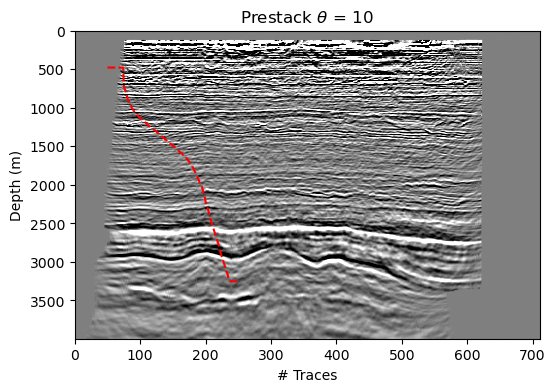

In [4]:
plt.figure(figsize=(6,4))
plt.imshow(seismicd_prestack_fence[:,10,:].T, cmap='gray', vmin=-1, vmax=1,
           extent=[0, seismicd_prestack_fence.shape[0], 
                   z_seismic_prestack_fence[-1], 
                   z_seismic_prestack_fence[0]])
# Plot the well trajectory
plt.plot(np.arange(len(zwell))[50:250], zwell[50:250], '--r')
plt.title('Prestack $\\theta$ = 10')
plt.xlabel('# Traces')
plt.ylabel('Depth (m)')
plt.axis('tight')

Plot the data in offset, angle, and the area of inversion

In [5]:
## Get the window depth for the prestack where the well log has information. 
window_min, window_max, well_start_data, well_end_data = get_depth_window_fence_Volve(well_vp_prestack_sampling=well_vp_prestack_sampling, 
                                                                                      zwell_seismic=zwell_seismic, 
                                                                                      z_seismic_prestack_fence=z_seismic_prestack_fence)

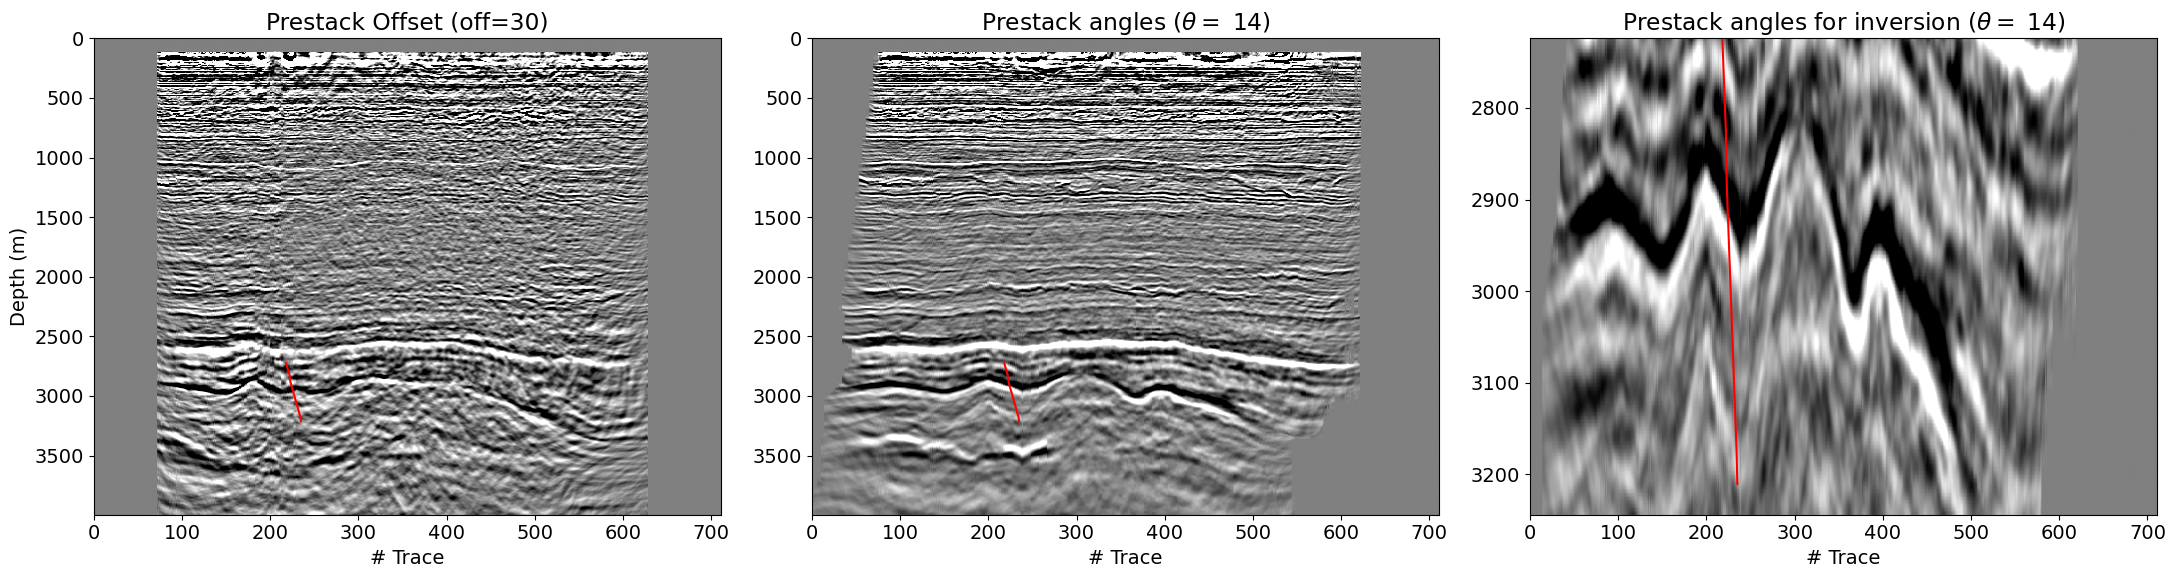

In [6]:
## Plot the data 
fig = plot_Volve_seismic_data(wellname=wellname, offset_num=30, angle=14, 
                            zwell=zwell, z_seismic_prestack_fence=z_seismic_prestack_fence, 
                            window_min=window_min, window_max=window_max, 
                            offset=offset, seismicd_prestack_fence=seismicd_prestack_fence,
                            fontsize=14, title_on=False)

Let's Visualize the prestack data only on the well

(0.0, 25.0, 3248.0, 708.0)

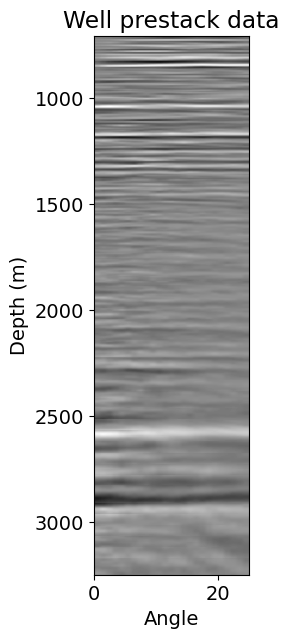

In [7]:
thetamin= 0
thetamax= 25
ntheta = 25

# Plot the real well prestack data
plt.figure(figsize=(2,7))
plt.imshow(well_prestack, extent=(thetamin, thetamax, zwell_seismic[-1], zwell_seismic[0]), cmap='gray')
plt.title('Well prestack data')
plt.xlabel('Angle')
plt.ylabel('Depth (m)')
plt.axis('tight')


### Well log information 

Here, we will present the available well log information, which will be utilized in the subsequent seis2rock training process. We first need a bit of cleaning.

In [8]:
#Processing elastic logs
vp, vs, rho, vp_back, vs_back, rho_back = process_well_logs(log_1=well_vp_prestack_sampling, 
                                                            log_2=well_vs_prestack_sampling, 
                                                            log_3=well_rho_prestack_sampling, 
                                                            depth_min=well_start_data, 
                                                            depth_max=well_end_data,
                                                            nsmooth=40)

#If AI and SI logs are needed: 
ai = vp*rho
si = vs*rho

#Processing petrophysical logs
phi, vsh, sw, phi_back, vsh_back, sw_back = process_well_logs(log_1=well_phi_prestack_sampling, 
                                                              log_2=well_vsh_prestack_sampling, 
                                                              log_3=well_sw_prestack_sampling, 
                                                              depth_min=well_start_data, 
                                                              depth_max=well_end_data,
                                                              nsmooth=40)


Plot the well logs available and the prestack data along the well

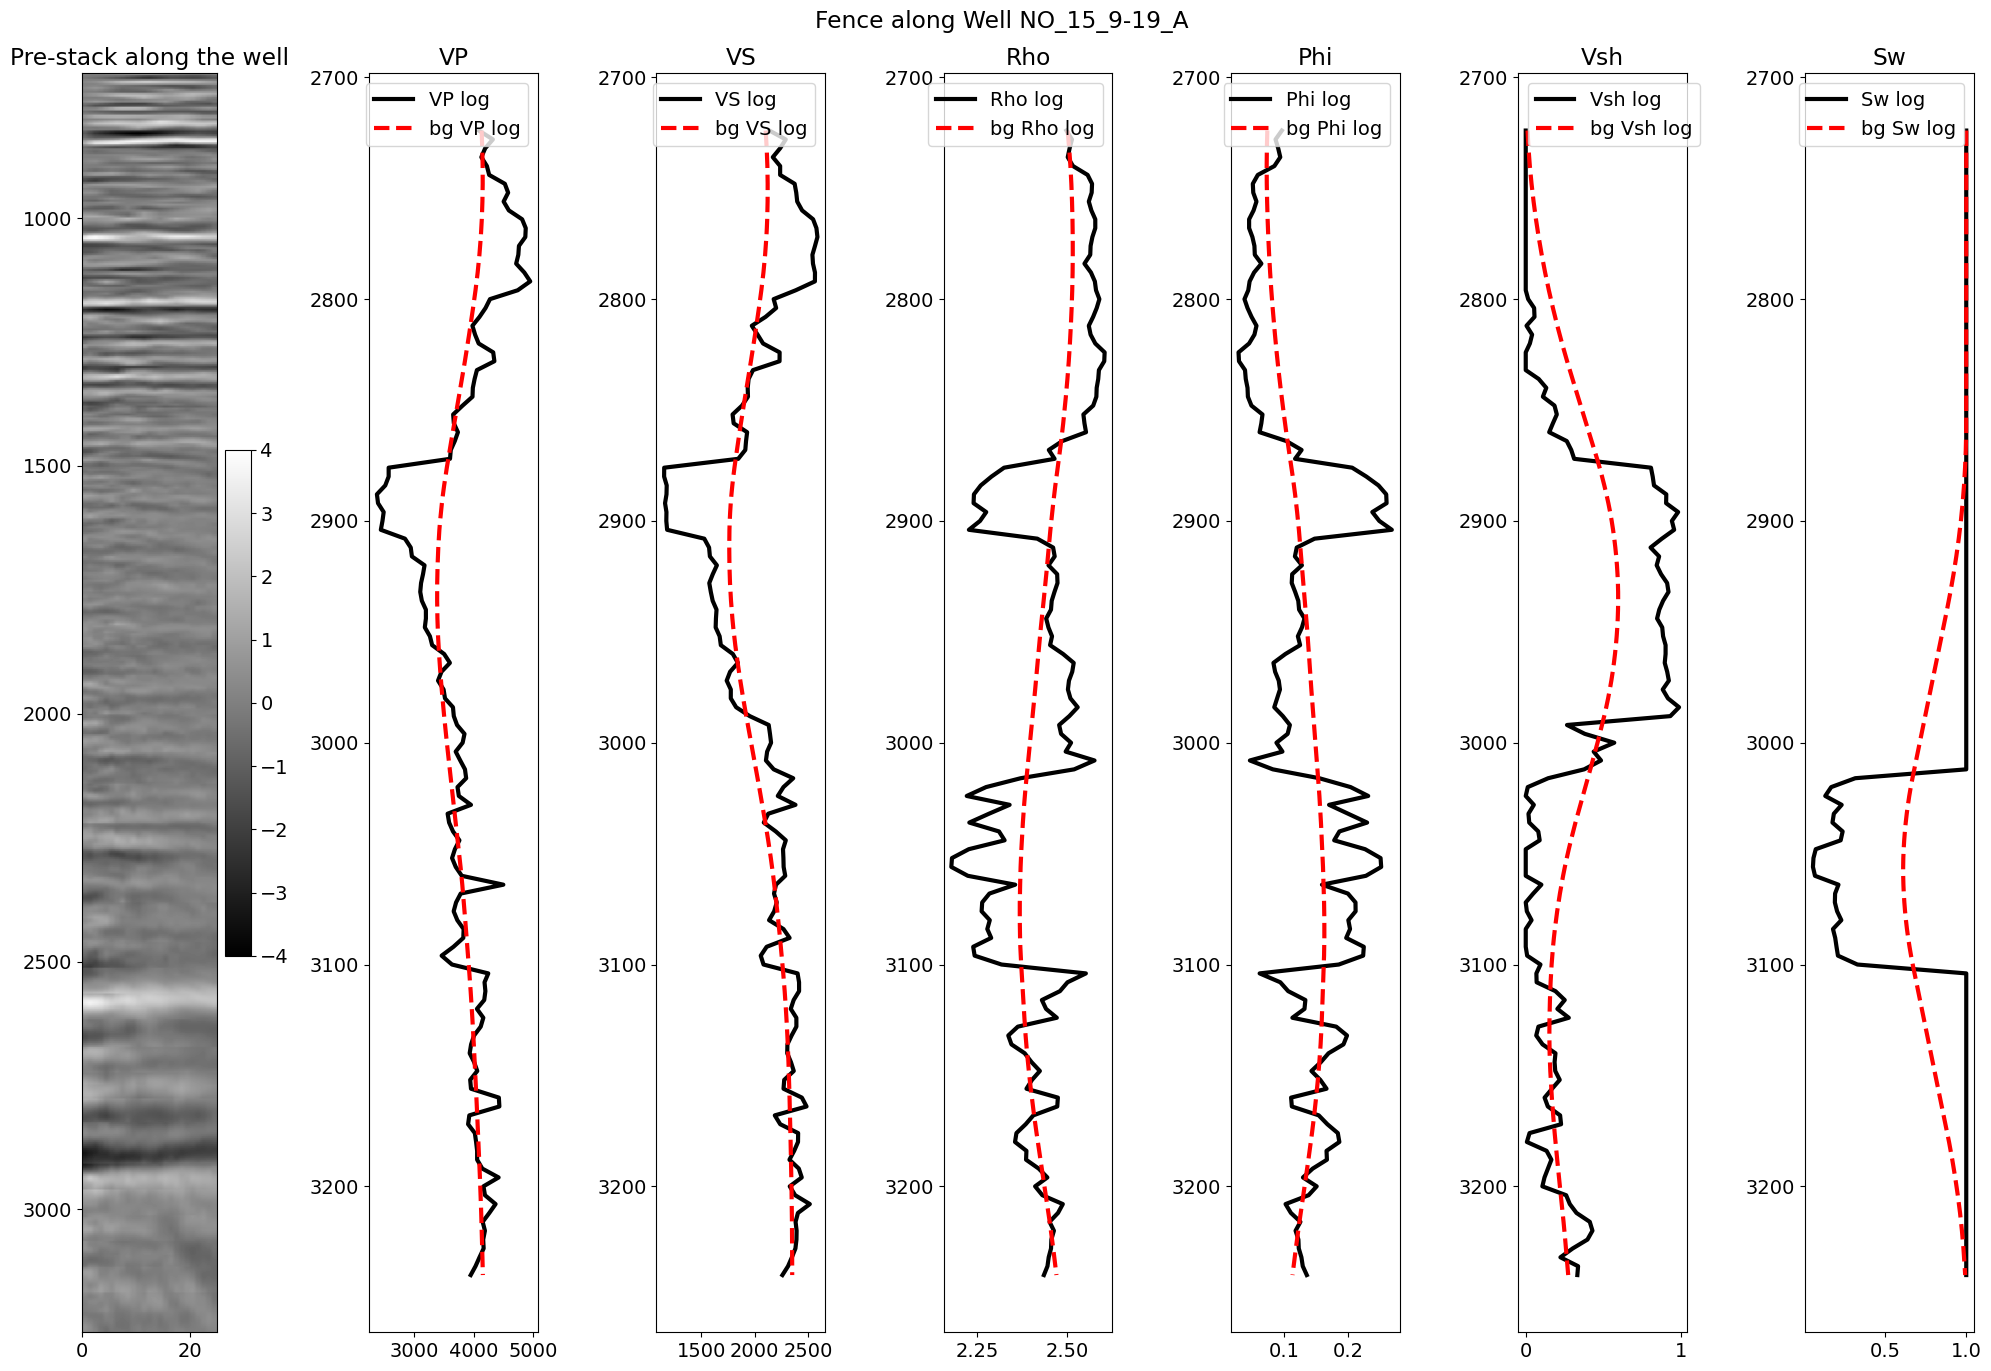

In [9]:
thetamin=0
thetamax=25
ntheta = 25

plot_set_logs(well_name='Fence along Well NO_15_9-19_A', 
              well_prestack=well_prestack, 
              extent_prestack=(thetamin, thetamax, zwell_seismic[-1], zwell_seismic[0]), 
              well_depth=zwell_seismic[well_start_data:well_end_data], 
              vp=vp, 
              vs=vs, 
              rho=rho, 
              phi=phi, 
              vsh=vsh, 
              sw=sw,
              vp_back=vp_back, 
              vs_back=vs_back, 
              rho_back=rho_back,
              phi_back=phi_back, 
              vsh_back=vsh_back, 
              sw_back=sw_back, 
              figsize=(20,14))

### Wavelet estimation

Lastly, we need to acquire the necessary wavelet. This step is crucial for further analysis and processing. Here we use the wavelet scaling obtained in one of the previous notebooks. 

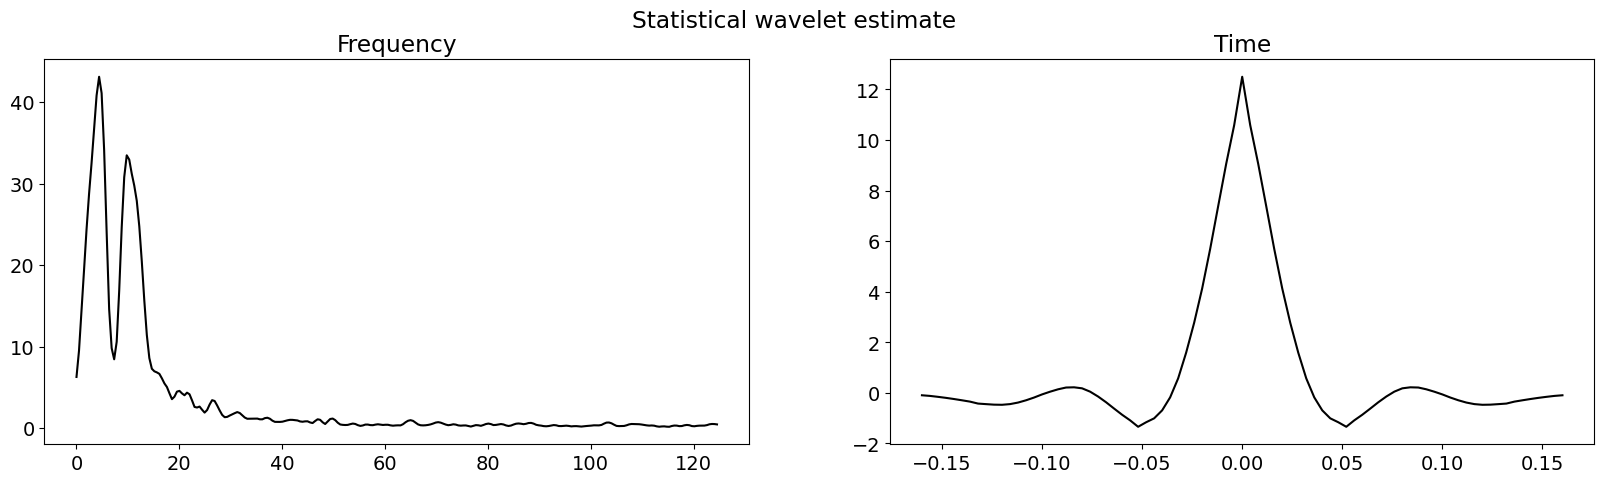

In [10]:
# Statistical Wavelet estimation
nfft = 512
nt_wav = 41
# wav_scaling =18
wav_scaling =12.5

wav_est, t_wav ,fwest, wav_est_fft = get_wavelet_estimate(nt_wav=nt_wav, nfft=nfft, wav_scaling=wav_scaling, 
                                    prestack_data=well_prestack[well_start_data:well_end_data].T[np.newaxis,:,:], 
                                    dt=dt)


# Display wavelet
display_wavelet(wav_est= wav_est, fwest=fwest, wav_est_fft=wav_est_fft, 
                t_wav= t_wav, nfft=nfft, fontsize = 14)

However, here we will create the synthetic gather using the well logs. This AVO will be used in the inversion

In [11]:
synthetic_gather  = avo_synthetic_gather(vp=vp, vs=vs, rho=rho,
                                         wav_est=wav_est, nt_wav=nt_wav, 
                                         thetamin=0, thetamax=25, ntheta=25)

In [12]:
d = synthetic_gather.T[np.newaxis,:,:] # To get the same dimensions as in the 2D case and use the same functions

## Seis2Rock framework

Now, we come to the most exciting part, where we apply the proposed methodology. We begin with the training phase, and it's important to note that we are not training any neural network in this context. The term "training" refers to obtaining the optimal basis functions $\mathrm{Fp}$ learned from the AVO synthetic gather.

In [13]:
# Select number of p optimal coeffcients 
p = 7
Fp, Lp, Vp, F, L, V, r_zoeppritz, r_zoeppritz_back, d_well = Seis2Rock_training(vp=vp, vs=vs, rho=rho, 
                                                                      wav_est=wav_est, nt_wav=nt_wav, 
                                                                      vp_back=vp_back, vs_back=vs_back, rho_back=rho_back, 
                                                                      p=p, 
                                                                      thetamin=0, thetamax=25, ntheta=25)

Computing AVO synthetic gathers from the well logs...
Performing SVD...
Extracting Optimal basis functions Fp..
Done! xD


Just to double check, let us look at the singular values

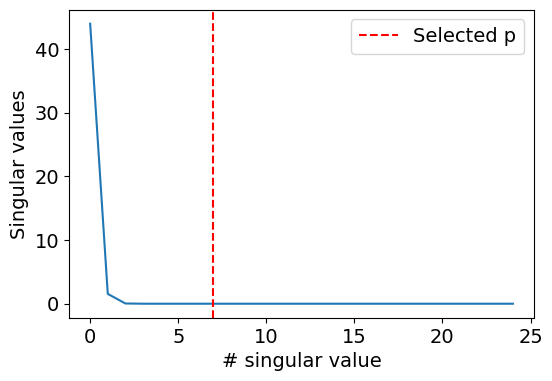

In [14]:
plt.figure(figsize=(6,4))
plt.plot(np.diag(-L))
plt.xlabel('# singular value')
plt.ylabel('Singular values')
plt.axvline(x=p, color='r', linestyle='--', label='Selected p')
plt.legend()
plt.axis('tight')
plt.show()

Now, we move on to the inference phase, where we obtain the optimal coefficients $\mathrm{Cp}$ and, consequently, the new data term $\mathrm{B}$, which represents the petrophysical reflectivities.

In [15]:
b_optAVO, r_zoeppritz_back, Cp, Hp, Cp_estimated = Seis2Rock_inference(vp=vp_back[np.newaxis,:], vs=vs_back[np.newaxis,:], rho=rho_back[np.newaxis,:], 
                                                         wav_est=wav_est, nt_wav=nt_wav, dtheta=d, 
                                                         Fp=Fp, Lp=Lp, Vp=Vp, 
                                                         phi=phi, vsh=vsh, sw=sw, 
                                                         phi_back=phi_back, vsh_back=vsh_back, sw_back=sw_back, 
                                                         d=d_well,
                                                         thetamin=0, thetamax=25, ntheta=25)

Computing AVO synthetic gather for background models...
Calculating matrix of optimal coefficients Cp...
Creating the new data term (Petrophysical coefficeints B)...
Done xD !


Now, we just need to perform the series of poststack seismic inversion per parameter

In [16]:
## Series of poststack seismic inversion (one per parameter)
## Here we use B as our 'new data term' which is the petrophysical coefficients

## Creating Post Stack Operator
kind = 'forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=b_optAVO.shape[1], 
                                                  spatdims=b_optAVO.shape[2],explicit=True, kind=kind)

## Creating Regularization (In this case Laplacian Regularization)
D2op  = Laplacian([b_optAVO.shape[1],  b_optAVO.shape[2]], dtype='float64', weights=(1,1000))



## Hyperparameters for optimization
niter = 500
lamba1 = 0.1
damp1 = 4


## Inverting for porosity
phi_inv_dense_reg = regularized_inversion(D, b_optAVO[0].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=(phi_back[np.newaxis,:].T.ravel()),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(phi_back[np.newaxis,:].T.shape) 

## Inverting for vsh
vsh_inv_dense_reg = regularized_inversion(D, b_optAVO[1].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=(vsh_back[np.newaxis,:].T.ravel()),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(vsh_back[np.newaxis,:].T.shape) 

## Inverting for sw
sw_inv_dense_reg = regularized_inversion(D, b_optAVO[2].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=sw_back[np.newaxis,:].T.ravel(),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(sw_back[np.newaxis,:].T.shape) 


And finally, the results on the well

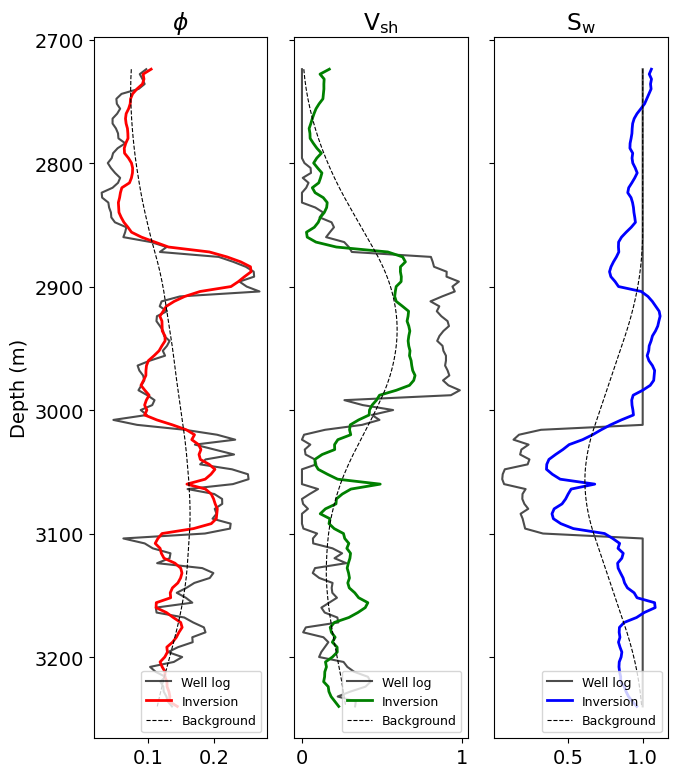

In [23]:
shift = 0
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 3, figsize=(7,8), sharey=True)
ax[0].plot(phi, zwell_seismic[well_start_data:well_end_data]+shift, label='Well log', color='k', linewidth=1.5, alpha=0.7)
ax[0].plot(phi_inv_dense_reg[:,0], zwell_seismic[well_start_data:well_end_data], label='Inversion',  color='r', linewidth=2)
ax[0].plot(phi_back, zwell_seismic[well_start_data:well_end_data], label='Background', color='k', linestyle='--',linewidth=0.8)
ax[0].set_title('$\phi$')
ax[0].set_ylabel('Depth (m)')
ax[0].invert_yaxis()
ax[0].legend(loc="lower right", fontsize=9)


ax[1].plot(vsh, zwell_seismic[well_start_data:well_end_data]+shift, label='Well log', color='k', linewidth=1.5, alpha=0.7)
ax[1].plot(vsh_inv_dense_reg[:,0], zwell_seismic[well_start_data:well_end_data], label='Inversion',  color='g', linewidth=2)
ax[1].plot(vsh_back, zwell_seismic[well_start_data:well_end_data], label='Background', color='k', linestyle='--',linewidth=0.8)
ax[1].set_title('$\mathrm{V_{sh}}$')
ax[1].invert_yaxis()
ax[1].legend(loc="lower right", fontsize=9)

ax[2].plot(sw, zwell_seismic[well_start_data:well_end_data]+shift, label='Well log', color='k', linewidth=1.5, alpha=0.7)
ax[2].plot(sw_inv_dense_reg[:,0], zwell_seismic[well_start_data:well_end_data],  label='Inversion',  color='b', linewidth=2)
ax[2].plot(sw_back, zwell_seismic[well_start_data:well_end_data], label='Background', color='k', linestyle='--',linewidth=0.8)
ax[2].set_title('$\mathrm{S_{w}}$')
ax[2].invert_yaxis()
ax[2].legend(loc="lower right", fontsize=9)

fig.tight_layout()

# fig.savefig('../../figures_results/inversion_well_A.png', format='png', dpi=300)
fig.show()

### Comparing petrophysical coefficients b

To accurately compare the petrophysical reflectivities, we construct our "$\mathrm{B}$" by utilizing the synthetic gather of well logs to obtain the corresponding $\mathrm{Cp}$

In [18]:
m_full = np.stack((phi, vsh, sw),axis=0)
m_back = np.stack((phi_back, vsh_back, sw_back),axis=0)

## To obtain the 'true' B, we need to apply the Poststack operator (wavelet and derivative)
Logsize = len(phi)
kind = 'forward' 
D = pylops.avo.poststack.PoststackLinearModelling(wav_est, nt0=Logsize, 
                                                  spatdims=Logsize,explicit=True, kind=kind) 

D_A = D.A.copy()

b_full_prof = D_A @ m_full[:,:].T
b_back_prof = D_A @ m_back[:,:].T

b_true = b_full_prof-b_back_prof

## Here we construct the B from the Cp and Hp matrices
# b_optAVO_comparison= Cp_estimated.T @ Hp.T @ (b_full_prof-b_back_prof)

Plot the comparison

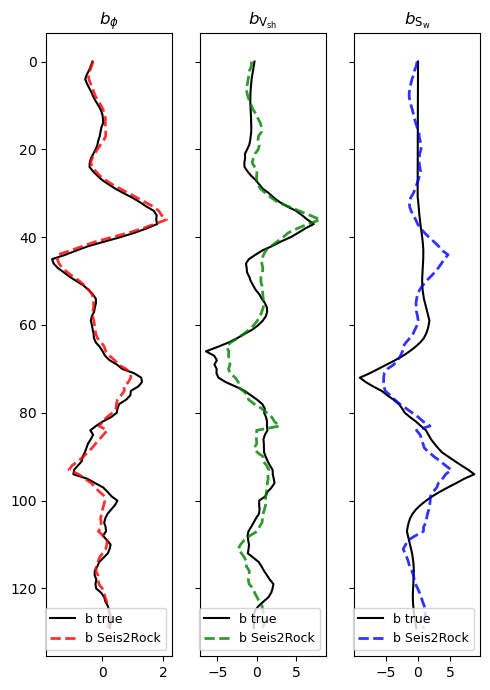

In [19]:
fig = plot_compare_b_reflectivities(b_true=b_true, b_optAVO=b_optAVO[:,:,0].T, fontsize=10)